In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2

import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Helper Functions

In [3]:
def showHeadTail(t_df,n=10,notebook=True):
    if notebook:
        from IPython.display import display
        display(pd.concat([t_df.head(n),t_df.tail(n)]))
    else:
        print(pd.concat([t_df.head(n),t_df.tail(n)]))
        
def getBothValCnts(df,col):
    return df[col].value_counts().to_frame('Count').join(df[col].value_counts(1).to_frame('Percent'),how='left')
        
def countUpper(df,col):
    df[col.upper()+'_UPPER_CNT'] = df[col].apply(lambda row: sum([1 for word in row.split() if word.isupper()]))
    return df

def exploreTokens(vect,arr,mdl,cnt=None):
    t_dtm = getDTM(vect,arr)
    t_df = DTMtoDF(t_dtm,vect)
    if showTokens:
        visualizeTokens(t_df,mdl,cnt)
        
def plotTokens(tokens,t_df):
    plt.scatter(t_df[0], t_df[1])
    for row in t_df.values:
        plt.annotate(s=tokens[int(row[0])],(row[1], row[2]))
    plt.show()
        
def visualizeTokens(t_df,mdl,cnt=None):
    X_T = t_df.T
    tokens = X_T.index.values.tolist()
    z = dr_mdl.fit_transform(X_T)
    z_df = pd.DataFrame(z)
    z_df['sum'] = abs(z_df[0]) + abs(z_df[1])
    z_df = z_df.sort_values('sum',ascending=False)
    z_df = z_df.reset_index().rename(columns={'index':'idx'})
    plotTokens(tokens,z_df.iloc[:cnt])
    return z,tokens

def juxtapose_categories(df,cat_col,val_col):
    options = df[cat_col].unique()
    df_juxtapose = pd.DataFrame()
    for opt in options:
        t_df = df.pivot(index='id',columns=cat_col,values=val_col)[[opt]].dropna().reset_index(drop=True)
        df_juxtapose = pd.concat([df_juxtapose,t_df],axis=1)
    return df_juxtapose

## Load Global Variables

In [4]:
####################
# GLOBAL VARIABLES #
####################
dta_pth = '../data/'
fn = 'news.csv'
f_pth = os.path.join(dta_pth,fn)
y_map = {'FAKE':0,'REAL':1}
X_col = 'title' # can be changed to 'text' to reproduce results for text of article column
y_col = 'label'
random_state = 42

showTokens = True
wordnet_lemmatizer = WordNetLemmatizer()

In [5]:
# Load the data
df = pd.read_csv(f_pth)
# encode y feature as Fake = 0, Real = 1
df['Target'] = df['label'].map(y_map)
print('File "{}": {} rows x {} columns\n'.format(fn,df.shape[0],df.shape[1]))
df.info()

File "news.csv": 6335 rows x 5 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 5 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
Target        6335 non-null int64
dtypes: int64(2), object(3)
memory usage: 247.6+ KB


## Create X matrix of independent variables and Y dataframe to hold targets
- Do this prior to exploring the data to keep original data and explored data separate
- Looking 

In [6]:
# y cols are in final two slots since encoded label as numeric
X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

# Quickly inspect the first and last few rows to get a very high level of the data contents
- The Title and Text fields represent the title of the article, while the text column contains the content for each article.
- The label column indicates whether the article is real or fake, which is also encoded as 1/0 in the Target column.
- The unnamed column is a unique ID for each article in the dataset.  This may be helpful later to keep track of our articles, so rename it ID

In [7]:
# Rename unnamed column to id
cols = df.columns.tolist()
cols[0] = 'id'
df.columns = cols
df.head()

,id,title,text,label,Target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


In [8]:
# first 10 entries
df.head(10)

,id,title,text,label,Target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE,0
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE,0
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL,1
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL,1
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL,1


In [9]:
# last 10 entries
df.tail(10)

,id,title,text,label,Target
6325,8411,Will the Media Reset After the Election or Are...,Written by Peter Van Buren venerable New Yor...,FAKE,0
6326,6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,FAKE,0
6327,3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,REAL,1
6328,9337,Radio Derb Is On The Air–Leonardo And Brazil’s...,,FAKE,0
6329,8737,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,FAKE,0
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,1
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL,1


# Explore the Independent and Dependent Variables

## Inspect the dependent variable, 'label' first
- The dependent variable 'label' is evenly distributed
- There are only two categories in this dataset

In [10]:
# use helper function that returns df of joined pd.value_count options 0 (ie, counts) and 1 (ie, percents)
getBothValCnts(df,'label')

,Count,Percent
REAL,3171,0.500552
FAKE,3164,0.499448


## Also, looking at the ID column the Real and Fake articles are sorted by ID
- Lower values are REAL articles and higher values are FAKE
- We can see this by doing a quick scatter plot

In [11]:
df.sort_values([df.columns[0]])

,id,title,text,label,Target
5603,2,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,REAL,1
565,3,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",REAL,1
2099,5,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,REAL,1
2197,6,"Despite Constant Debate, Americans' Abortion O...",It's been a big week for abortion news.\n\nCar...,REAL,1
5974,7,Obama Argues Against Goverment Shutdown Over P...,President Barack Obama said Saturday night tha...,REAL,1
...,...,...,...,...,...
1213,10549,French Political Leader: “France is about to E...,"Posted on October 31, 2016 by Theodore Shoebat...",FAKE,0
4863,10551,Man with unfashionable front door feared by ne...,Man with unfashionable front door feared by ne...,FAKE,0
5397,10553,Obamacare Architect on Rising Premiums: It’s N...,"Washington Free Beacon October 26, 2016 \nDr. ...",FAKE,0
208,10555,Clinton Vs. Trump: Latest Electoral Prediction...,(Before It's News)\nIt is fun to look at polls...,FAKE,0


## Scatter of y variable by ID

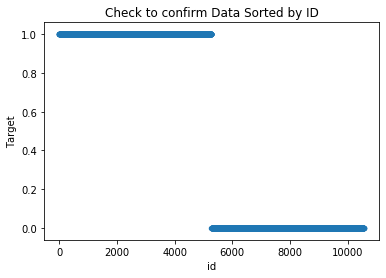

In [12]:
df.plot(kind='scatter',x='id',y='Target')
plt.title('Check to confirm Data Sorted by ID')
plt.show()

# Explore the dependent data, 'title' and 'text'

## 'Nulls'
### While the dataframe does not have any Null values as seen at the import stage, check at a high level and see if any the contents of the Text and Title column carry emptry strings.
- The Title field only appears to contain one row with a 'missing' title as shown by the single row with a string length of 1.  The next shortest is 5.  Assume titles of length <=1 are "nu

In [13]:
df['title'].apply(lambda x: len(x)).value_counts().sort_index()

1      1
5      1
8      2
9      4
10     2
      ..
221    1
229    2
231    1
269    1
289    1
Name: title, Length: 168, dtype: int64

In [14]:
df.loc[df['title'].apply(lambda x: len(x) <= 5),'title']

2417    White
3456        :
Name: title, dtype: object

### There are a few dozen rows in the Text column which  appear to contain only empty string values.  
- 36 title have a length of just 1, 
- The next shortest length, as 12 characters long.

In [15]:
# It appears that 36 of the artilces do not have any text as shown by this value count on string length
df['text'].apply(lambda x: len(x)).value_counts().sort_index()

1         36
12         1
13         1
17         1
34         1
          ..
56795      1
68208      1
92561      1
99355      1
115372     1
Name: text, Length: 4562, dtype: int64

### Inspecting these that rows only have empty strings for the text contents, we see that they are all FAKE articles.  There are a few options for handling this missing data.  
1. Leave the missing information as is
2. Impute the TITLE values for the text values.
3. Remove these rows from the data set.

At this point, it is too early to say which is the 'best' option.  The best answer depends on a few things: 
    <li> **a)** which scenario will most represent the real-world, out of sample articles the model will be classifying (ie, do all articles missing a text component get set to FAKE by default prior to modeling? </li>
    <li> **b)** which column features we end up using to build our final model </li>

In [16]:
df.loc[df['text'].apply(lambda x: len(x) == 1), :]

,id,title,text,label,Target
106,5530,The Arcturian Group by Marilyn Raffaele Octobe...,,FAKE,0
710,8332,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,FAKE,0
806,9314,Southern Poverty Law Center Targets Anti-Jihad...,,FAKE,0
919,10304,Refugee Resettlement Watch: Swept Away In Nort...,,FAKE,0
940,9474,Michael Bloomberg Names Technological Unemploy...,,FAKE,0
1664,5802,Alert News : Putins Army Is Coming For World W...,,FAKE,0
1736,9564,An LDS Reader Takes A Look At Trump Accuser Je...,,FAKE,0
1851,5752,America’s Senator Jeff Sessions Warns of Worse...,,FAKE,0
1883,8816,Paris Migrant Campers Increase after Calais Is...,,FAKE,0
1941,7525,Putins Army is coming for World war 3 against ...,,FAKE,0


## For this analysis, assume option two and impute the title values for missing text value 
- This won't assume these rows will be filtered out in a real world scenario 
- It will still capture relevant information for each of these articles missing text


In [17]:
# set blank text entries to that articles title text 
df.loc[df['text'].apply(lambda x: len(x) == 1), 'text'] = df.loc[df['text'].apply(lambda x: len(x) == 1), 'title']

## Visually inspect the tokens  
- Start with the Title column first
- These are shorter than full text of articles so this should be a good starting point before diving into full text

In [136]:
# create a tokenizer that cleans converts raw text to lemmas of tokens using NLTK
# NB: add regex to remove non-alphanermic tokens and tokens that are all digits
def getLemms(s):
    return [wordnet_lemmatizer.lemmatize(t.strip()) for t in nltk.tokenize.word_tokenize(s) if t not in r'''!'?s’-:,@;#$.%"^""&*.'.''.''']

In [146]:
# initialize a vectorize using our lemma tokenizer and removing english stop words
#vect = CountVectorizer(tokenizer=getLemms,strip_accents='unicode', stop_words = 'english')
vect = CountVectorizer(strip_accents='unicode', stop_words = 'english')

In [147]:
# convert the titles to a document term matrix
dtm = vect.fit_transform(df['title'])

In [148]:
### transform titles from columns of single strings to a sparse DTM: document term matrix
dtm

<6335x9820 sparse matrix of type '<class 'numpy.int64'>'
	with 44923 stored elements in Compressed Sparse Row format>

In [156]:
### convert DTM sparse matrix to a sparse DataFrame with TOKENS AS COLUMNS
df_dtm = pd.DataFrame(dtm.toarray(),columns=vect.get_feature_names())
df_dtm.sample(10,random_state=random_state)

,00,000,00pm,01,04,05,06,08,10,100,...,ارزی,القادمون,امریکا,ایران,جنگ,سال,علیه,مطالعاتی,مورد,کدامایی
1357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
812,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## There are ~9800 different tokens, which are the most important?  Will we need all of them for building a model?
- Use Singular Value Decomposition to find out which ones contain the most "hidden" information.
- This hidden information indicates how far apart the tokens are from each other and the magnitude of that difference
- Later we'll look at removing tokens both by LSA to obtain more components (SVD with a range of components) and parameter tuning on Count and Tfidf Vectorizers.

In [159]:
# The most frequent tokens are shown below: 
# not suprisingly Trump, Clinton, Hillary and Obama are the most common 
# as they all were President or their respective Party Nominees for President
df_dtm.sum(axis=0).sort_values(ascending=False).to_frame('Token_Counts')

,Token_Counts
trump,1115
clinton,723
hillary,591
obama,378
new,280
...,...
mckesson,1
mckinley,1
mckinsey,1
mcmahon,1


### Transpose the Document Term Matrix to a Term-Document Matrix with the TOKENS AS ROWS for input into SVD

In [157]:
# The Transposed dataframe now shows the tokens in the index and has 1 column for each of the 6335 documents in data
new_X = df_dtm.T 
new_X.sample(10,random_state=random_state)

,0,1,2,3,4,5,6,7,8,9,...,6325,6326,6327,6328,6329,6330,6331,6332,6333,6334
provocative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gambling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arabian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
warplane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
advertisers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
contamination,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paperwork,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
monopoly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chose,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Transform these 6335 document term-counts into 2 components using SVD and graph the results
- Create a list of the unique tokens in order to graph them with corresponding transformed values

In [165]:
# list of unique individual tokens
tokens = new_X.index.values.tolist()
# instantiate default SVD object, which defaults to 2 components
dr_mdl = TruncatedSVD()
# fit_transform the token term-document matrix using SVD object
z = dr_mdl.fit_transform(new_X)
# inspect transformed data, which is stored as a numpy matrix
z[:11,:]

array([[ 2.24639536e-02, -1.56802326e-02],
       [ 1.96298607e-01,  3.59853387e-01],
       [ 4.69996531e-03,  5.21748796e-03],
       [ 3.01215763e-02, -1.94302234e-02],
       [ 1.00534675e-03,  1.42894558e-03],
       [ 9.36661547e-05, -1.42952972e-05],
       [ 2.12469110e-03,  2.41393603e-03],
       [ 1.67617789e-03,  1.94490796e-03],
       [ 1.65754490e-01,  9.24452601e-04],
       [ 5.81451358e-02,  5.13831243e-02],
       [ 4.24022610e-04, -6.49547221e-05]])

In [167]:
# convert the numpy matrix z into a dataframe
z_df = pd.DataFrame(z)
z_df.head()

,0,1
0,0.022464,-0.015680
1,0.196299,0.359853
2,0.004700,0.005217
3,0.030122,-0.019430
4,0.001005,0.001429


In [168]:
# plot the tokens
%matplotlib inline
cnt = 100

t_df = z_df.iloc[:cnt]
plt.scatter(t_df[0], t_df[1])
for row in t_df.values:
    plt.annotate(s=tokens[int(row[0])],(row[1], row[2]))
plt.show()

NameError: name 'plotTokens' is not defined

## Grab a random sample of the title data to visually explore the differences and see if we can get any intuition about what might drve discrepencies between REAL and FAKE article titles

In [392]:
def juxtapose_categories(df,idx,cat_col,val_col):
    options = df[cat_col].unique()
    df_juxtapose = pd.DataFrame()
    for opt in options:
        t_df = df.pivot(index=idx,columns=cat_col,values=val_col)[[opt]].dropna().reset_index(drop=True)
        df_juxtapose = pd.concat([df_juxtapose,t_df],axis=1)
    return df_juxtapose

In [393]:
pd.set_option('display.max_colwidth', -1) 
juxtapose_categories(df,'id',y_col,'title').sample(10,random_state=7)

label,FAKE,REAL
2325,Comment on Sweden on the brink? Police force pushed to breaking point by violence amid migrant influx by Paul Blake,Angela Merkel to Visit White House on Feb. 9
3031,Putin: Russia Is Not Going To Attack Anyone,Historic firsts fill evening at Democratic National Convention
638,Arkansas Republicans Put The Word “Liar” In Hillary’s Name On Ballot,Bernie Sanders' big day
2039,World wildlife ‘falls by 58% in 40 years’,Scalia lies in repose at Supreme Court
1490,Trump: A people’s ‘new world order’ taking shape?,Seeking Refuge: Five lessons from Europe's migration crisis
2899,"PIERS MORGAN: “Get Off Your High Horse, Hillary. Only ONE Candidate is Up To Her Neck in FBI Probes and Her Name Isn’t Donald” – TruthFeed","Trump doctor’s letter: He takes cholesterol drug, is overweight but is in ‘excellent’ health"
1262,President Trump! A nightmare of the Ukrainian politicians! (English subs),How America is quietly becoming a climate change leader
1232,Is Trump winning? The future of America depends on a few states,DR. MANNY: Water crisis in Flint is just the tip of the iceberg
1364,Dr. Duke and Dr. MacDonald Call for Prosecution of Hillary for Treasonous Support of ISIS.,Meet The Couples Fighting To Make Marriage Equality The Law Of The Land
1271,The Loosening Grip,Earth had warmest winter on record


# Now, let's take a look at a few random samples of the Text contents too
- Since these are much larger, I'll only grab a row at a time and check 10 of these.
- Looking at this small handful, it is hard to get develop any intuitive insight like we did with the Title column. 

In [415]:
pd.set_option('display.max_colwidth', -1)
juxtapose_categories(df,'id',y_col,'text').sample(1,random_state=7)

label,FAKE,REAL
2325,"DCG | 5 Comments \nAin’t multiculturalism grand? \nFrom Daily Express : The Scandinavian country is facing an existential crisis with on average three police officers handing in their resignations a day. If the alarming trend continues, and police officers continue to resign more than 1,000 officers will have quit the service by New Years. \nSince the migrant crisis began last summer, Sweden has been hit by a series of brutal crimes and violent incidents . In 2015 alone Sweden, with a population of 9.5million, received over 160,000 asylum applications and the country is expected to take as many as 190,000 refugees, or two per cent of the population, by the end of 2016. \nSince the Second World War Sweden has prided itself on helping migrants who cross their borders despite some moves to the political right in recent years. \nBut police have now admitted the force has reached breaching point as more than 50 areas in the country have now been placed on a “no-go zone” list . \nIn February a report from Sweden’s National Criminal Investigation Service announced there were 52 areas where officers would not cope with the levels of crime being committed . Sex assaults , drug dealing and children carrying weapons were just some of the incidents mentioned in the report. In September, Swedish officials were forced to add another three areas to the list. \nNow the Police Association have said they need at least 200 new officers to regain control in the south-east of the country. \nThomas Stjernfeldt, from the region’s police association, told SVT : “We are missing extremely many officers in the operational sector, right now we need 200 more officers to be added to the force to establish a reasonable working environment in the southeast of Götaland .” Götaland is one of the regions in the country that has been hit hard by the car fire attacks, which have been occurring throughout Sweden. \nOn Monday, Express.co.uk reported a number of the arsonist attacks in the city of Växjö, in Götaland, had been committed by frustrated migrants . Currently there are more than 6,000 suspected crimes that are unsolved in the area and 400 of these cases are suspected to be rapes, murder or attempted murder. \nMr. Stjernfeldt said the figures are alarming and police officers are constantly forced to work overtime in an attempt to solve the reported crimes. \nThe Police Association admitted it fears the public will lose faith in the force and their ability to protect citizens if the situation is not resolved. \nThe union’s call for more resources echoes National Police Commissioner Dan Eliasson’s February warning, where he said he needed a further 4,100 officers and specialist staff to reestablish law and order in Sweden. \nDCG","President Barack Obama will play host to German Chancellor Angela Merkel in Washington, D.C. next week, the White House announced Monday.\n\nMs. Merkel will visit the White House on Feb. 9, where she and the president are expected to discuss issues like Russia, Ukraine, counterterrorism and the challenges in the broader Middle East. The two leaders will have an Oval Office meeting followed by a working lunch."


In [416]:
pd.reset_option('display')

### Iterating through a few random samples of FAKE vs REAL records, one trend that seems to emerge: FAKE entries tend to have a higher number of UPPERCASE words in the Title and potentially in the text as well.
- Given this, it might be worth while to count of the number of uppercase words in the title could be one potential feature for use in a model later, so let's grab create a column with that information

In [417]:
def countUpper(df,col):
    df[col.upper()+'_UPPER_CNT'] = df[col].apply(lambda row: sum([1 for word in row.split() if word.isupper()]))
    return df

In [418]:
df = countUpper(df,'title')
df = countUpper(df,'text')

In [419]:
df.head()

,id,title,text,label,TITLE_UPPER_CNT,TEXT_UPPER_CNT
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,38
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2,3
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,0,6
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,1,5
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,0,3


### Let's take a look at how this count of uppercase words feature looks.
- Looking at the quartile breakdown of the Distribution of count of uppercase words in the the Title column, we see  there could be a divergence starting somewhere in the 3rd or 4th quartile, but it's difficult to tell from this view alone.

In [420]:
df.groupby('label')['TITLE_UPPER_CNT'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
FAKE,3164.0,0.731669,1.717771,0.0,0.0,0.0,1.0,17.0
REAL,3171.0,0.246295,0.494335,0.0,0.0,0.0,0.0,5.0


### So let's take a closer look at the distribution and visualize it in more detail 
- To get a better sense, let's look at how many Titles contain up to 5 uppercase words
- It appears that there are in fact more uppercase words in FAKE titles compared to the REAL, but is this difference 'significant'.
- Let's store the distribution of each in the *'t_distro'* dictionary variable

In [20]:
word_cnt = 5
t_distro = {}
for g,f in df.groupby(y_col):
    for cnt in range(word_cnt):
        temp_cat = f.loc[f[y_col] == g,'TITLE_UPPER_CNT'].tolist()
        #t_distro[g] = pd.Series([np.percentile(temp_cat,p) for p in range(101)])
        t_distro[g] = pd.Series([int(np.percentile(temp_cat,p)) for p in range(101)])
        print('{} News Titles: {}% Contain at least {} Upper Case Word.'.format(g,100-t_distro[g].loc[t_distro[g] > cnt].idxmin(),cnt+1))
    print()

FAKE News Titles: 37% Contain at least 1 Upper Case Word.
FAKE News Titles: 12% Contain at least 2 Upper Case Word.
FAKE News Titles: 5% Contain at least 3 Upper Case Word.
FAKE News Titles: 3% Contain at least 4 Upper Case Word.
FAKE News Titles: 2% Contain at least 5 Upper Case Word.

REAL News Titles: 22% Contain at least 1 Upper Case Word.
REAL News Titles: 2% Contain at least 2 Upper Case Word.
REAL News Titles: 0% Contain at least 3 Upper Case Word.
REAL News Titles: 0% Contain at least 4 Upper Case Word.
REAL News Titles: 0% Contain at least 5 Upper Case Word.



### Let's try a visualizing the Information with a boxplot to see if that helps
- This shows us that from the median to Q3 of the IQR FAKE articles have 1 upper case word, whereas REAL articles in show an IQR of 0, with only outliters having 1 or more.  This is further evidence that this feature is likely helpful in distinguishing between the two

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


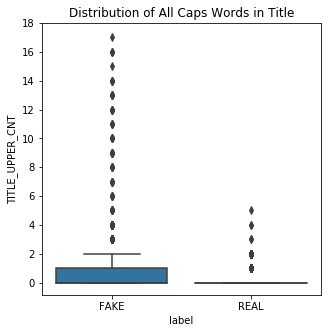

In [21]:
# Import the necessary visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import numpy as np
%matplotlib inline

# check visually with BoxPlot
plt.figure(figsize=(5,5))
sns.boxplot(df[y_col],df['TITLE_UPPER_CNT'])
plt.yticks(range(0,19,2))
plt.title('Distribution of All Caps Words in Title')
plt.show()

### Let's try zooming in on this upper half of the distribution and visualizing the Information with line graphs to get a more detailed view

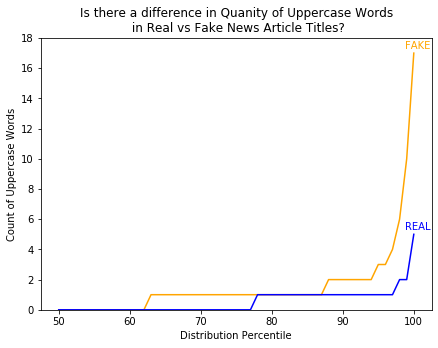

In [22]:
d_color = {'FAKE':'orange','REAL':'blue'}

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
#ax.yaxis.tick_right()

plt.xticks(range(0,t_distro['FAKE'].index.max()+1,10))
plt.ylim([0,t_distro['FAKE'].values.max()+1])
plt.yticks(range(0,20,2))
plt.title('Is there a difference in Quanity of Uppercase Words\n in Real vs Fake News Article Titles?')
plt.xlabel('Distribution Percentile')
plt.ylabel('Count of Uppercase Words')


plt.plot(t_distro['FAKE'].index.tolist()[50:],t_distro['FAKE'].values.tolist()[50:],color=d_color['FAKE'],label='FAKE')
plt.plot(t_distro['REAL'].index.tolist()[50:],t_distro['REAL'].values.tolist()[50:],color=d_color['REAL'],label='REAL')

plt.text(x=t_distro['FAKE'].index.max()-1.2, y =t_distro['FAKE'].values.max()+.3,s='FAKE',color=d_color['FAKE'])
plt.text(x=t_distro['REAL'].index.max()-1.2, y =t_distro['REAL'].values.max()+.3,s='REAL',color=d_color['REAL'])
#plt.legend(bbox_to_anchor=(1, 1),
#           bbox_transform=plt.gcf().transFigure)
plt.show()


### So it looks promising to add this feature, but to validate this hypothesis let's check using a two-way Chi-Square test.
- Here we see that FAKE articles have a long tail, with up to 17 uppercase words in a single title, whereas the REAL artilces have up to a maximum of 5 in a single instance.  And only 5 REAL articles out of the 3100+ samples have more than 2 uppercase words.

In [23]:
tbl_contingency = pd.crosstab(df[y_col],df['TITLE_UPPER_CNT'])
tbl_contingency

TITLE_UPPER_CNT,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
label,,,,,,,,,,,,,,,,,,
FAKE,1985,785,213,69,31,12,6,9,6,11,7,5,7,6,6,1,4,1
REAL,2469,632,65,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0


### Given the extreme outliers in REAL articles with more than 2 uppercase words, let's refactor this feature as 0,1 2, or 2+ (encoded as 3) upper case words
- This will enable us to use the Chi-Squared test, which operates under the assumption that 80% of cells in the contingency table contain a value count of at least 5, with no cells having less a value count of less than 1. **[source](http://www.google.com)**
- An added advantage is that when we get to the modeling phase, this simplified feature will be more generalizable by our model since it will only result in 3 levels for a model to consider as opposed to 18.

In [24]:
df['TITLE_UPPER_CNT_2'] = df['TITLE_UPPER_CNT'].apply(lambda x: x if x <=2 else 3)

In [25]:
tbl_contingency = pd.crosstab(df[y_col],df['TITLE_UPPER_CNT_2'])
tbl_contingency

TITLE_UPPER_CNT_2,0,1,2,3
label,,,,
FAKE,1985,785,213,181
REAL,2469,632,65,5


### The Chi-Squared test confirms our hypothesis, that the target variable is likely dependent on the engineered feature variable of Uppercase word count in the Title

In [26]:
significance_threshold = 0.05

from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(tbl_contingency)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > significance_threshold:
	print('Probably independent')
else:
	print('Probably dependent')

stat=314.436, p=0.000
Probably dependent


### Let's look at applying the same approch to Chi-Squared for the count of upper case words in TEXT
- Right off the bat, the describe method seems to indicate less variability in this feature between the two target labels, so my initial hypothesis would be that the target variable is not dependent on the count of uppercase words in the TEXT feature.

In [27]:
df.groupby('label')['TEXT_UPPER_CNT'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
FAKE,3164.0,12.992731,24.822244,0.0,3.0,7.0,15.0,697.0
REAL,3171.0,10.690634,13.385306,0.0,3.0,7.0,14.0,146.0


/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


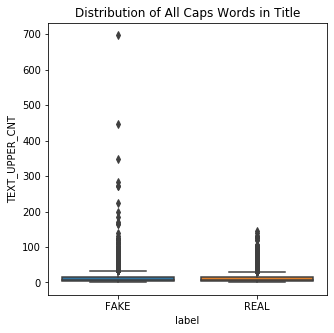

In [28]:
# Import the necessary visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import numpy as np
%matplotlib inline

# check visually with BoxPlot
plt.figure(figsize=(5,5))
sns.boxplot(df[y_col],df['TEXT_UPPER_CNT'])
#plt.yticks(range(0,19,2))
plt.title('Distribution of All Caps Words in Title')
plt.show()

# Given the wide range of all caps words found in the Text documents, we can transform the range by taking the log of this feature
- In this case, there seems to be far less variability in the distributions of uppercase words between the two labels

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


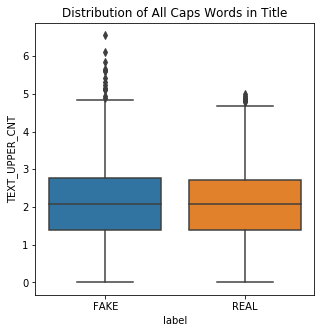

In [29]:
# Import the necessary visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import numpy as np
%matplotlib inline

# check visually with BoxPlot
plt.figure(figsize=(5,5))
sns.boxplot(df[y_col],np.log1p(df['TEXT_UPPER_CNT']))
#plt.yticks(range(0,19,2))
plt.title('Distribution of All Caps Words in Title')
plt.show()

### For completeness, let's confirm with the two-way Chi-Squared test
- Looking at the contingency table, no good cutoff number emerges since both FAKE and REAL articles have such large numbers

In [30]:
tbl_contingency = pd.crosstab(df[y_col],df['TEXT_UPPER_CNT'])
tbl_contingency

TEXT_UPPER_CNT,0,1,2,3,4,5,6,7,8,9,...,166,171,184,200,223,272,282,348,446,697
label,,,,,,,,,,,,,,,,,,,,,
FAKE,277,230,230,211,214,187,173,145,135,119,...,1,1,1,1,1,2,1,1,1,1
REAL,276,177,186,183,200,220,196,175,184,132,...,0,0,0,0,0,0,0,0,0,0


### Maybe a closer look at the distributions will help

In [31]:
word_cnt = 10
t_distro = {}
for g,f in df.groupby(y_col):
    for cnt in range(word_cnt):
        temp_cat = f.loc[f[y_col] == g,'TEXT_UPPER_CNT'].tolist()
        #t_distro[g] = pd.Series([np.percentile(temp_cat,p) for p in range(101)])
        t_distro[g] = pd.Series([int(np.percentile(temp_cat,p)) for p in range(101)])
        print('{} News TEXT: {}% Contain at least {} Upper Case Word.'.format(g,100-t_distro[g].loc[t_distro[g] > cnt].idxmin(),cnt+1))
    print()

FAKE News TEXT: 91% Contain at least 1 Upper Case Word.
FAKE News TEXT: 83% Contain at least 2 Upper Case Word.
FAKE News TEXT: 76% Contain at least 3 Upper Case Word.
FAKE News TEXT: 70% Contain at least 4 Upper Case Word.
FAKE News TEXT: 63% Contain at least 5 Upper Case Word.
FAKE News TEXT: 57% Contain at least 6 Upper Case Word.
FAKE News TEXT: 51% Contain at least 7 Upper Case Word.
FAKE News TEXT: 47% Contain at least 8 Upper Case Word.
FAKE News TEXT: 43% Contain at least 9 Upper Case Word.
FAKE News TEXT: 39% Contain at least 10 Upper Case Word.

REAL News TEXT: 91% Contain at least 1 Upper Case Word.
REAL News TEXT: 85% Contain at least 2 Upper Case Word.
REAL News TEXT: 79% Contain at least 3 Upper Case Word.
REAL News TEXT: 74% Contain at least 4 Upper Case Word.
REAL News TEXT: 67% Contain at least 5 Upper Case Word.
REAL News TEXT: 60% Contain at least 6 Upper Case Word.
REAL News TEXT: 54% Contain at least 7 Upper Case Word.
REAL News TEXT: 49% Contain at least 8 Upper C

#### A graph of these respective distributions shows they diverge at the tail ends
- Zooming in on the upper 10% of the distribution, shows divergence at the 99th percentile.
- Given this and the raw numbers from the t_distro cell above, I will set the upper end for both to 10 to balance feature value and model simplicity

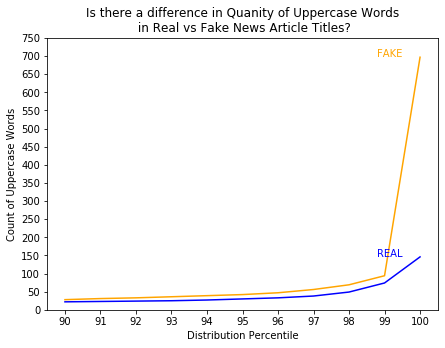

In [32]:
d_color = {'FAKE':'orange','REAL':'blue'}

zoom_lower = 90
zoom_upper = None
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
#ax.yaxis.tick_right()

plt.xticks(range(0,t_distro['FAKE'].index.max()+1,10))
plt.ylim([0,t_distro['FAKE'].values.max()+1])
plt.yticks(range(0,751,50))
plt.xticks(range(90,101,1))
plt.title('Is there a difference in Quanity of Uppercase Words\n in Real vs Fake News Article Titles?')
plt.xlabel('Distribution Percentile')
plt.ylabel('Count of Uppercase Words')


plt.plot(t_distro['FAKE'].index.tolist()[zoom_lower:zoom_upper],t_distro['FAKE'].values.tolist()[zoom_lower:zoom_upper],color=d_color['FAKE'],label='FAKE')
plt.plot(t_distro['REAL'].index.tolist()[zoom_lower:zoom_upper],t_distro['REAL'].values.tolist()[zoom_lower:zoom_upper],color=d_color['REAL'],label='REAL')

plt.text(x=t_distro['FAKE'].index.max()-1.2, y =t_distro['FAKE'].values.max()+.3,s='FAKE',color=d_color['FAKE'])
plt.text(x=t_distro['REAL'].index.max()-1.2, y =t_distro['REAL'].values.max()+.3,s='REAL',color=d_color['REAL'])
#plt.legend(bbox_to_anchor=(1, 1),
#           bbox_transform=plt.gcf().transFigure)
plt.show()

### Limiting the value count to 10 is a compromise between extracting value from the feature while at the same time minimizing complexity of the model that will likely be quite sparce once the text is converted to a document term matrix of tfidf scores.
- An instance of the bias-variance trade-off.  Including the entire range of known values would increase the variability, but would increase model complexity and lead to overfitting of any model we build later.

In [33]:
df['TEXT_UPPER_CNT_2'] = df['TEXT_UPPER_CNT'].apply(lambda x: x if x <=10 else 10)

In [34]:
tbl_contingency = pd.crosstab(df[y_col],df['TEXT_UPPER_CNT_2'])
tbl_contingency

TEXT_UPPER_CNT_2,0,1,2,3,4,5,6,7,8,9,10
label,,,,,,,,,,,
FAKE,277,230,230,211,214,187,173,145,135,119,1243
REAL,276,177,186,183,200,220,196,175,184,132,1242


### A chi-square test shows that the target feature might be dependent on the number of upperacase words in the text.  
- This is not what I hypotheszied, however given this result, I will hold onto the variable for potential use in a model.

In [35]:
significance_threshold = 0.05

from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(tbl_contingency)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > significance_threshold:
	print('Probably independent')
else:
	print('Probably dependent')

stat=29.135, p=0.001
Probably dependent


# Convert Text to Machine Readable Format for Modeling - Vectorizers
- Bag-of-words
- Count vs Tf-Idf vectorizer
- Brief overview of the concepts and math
- Touch on curse of dimensionality
- Mention ways to address this with Vectorizer function arguments
- Visualize top words by Target type 
    - heat map?
    - somehow show the top 25 words 'associated' with each category -> what is the test for this?

In [36]:
X.head()

,Unnamed: 0,title,text
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...


### Convert Title column to a  Document Term Matrix of TfIdf scores
- Balances importance of each token with-in a single document (ie, count of each word in a single Title) vs importance of each token across all documents (ie, count of each word in all of the Titles in the title column)
- Mathematically:
    

In [37]:
dtm_col = 'title'
vect = TfidfVectorizer()
X_dtm = vect.fit_transform(X[dtm_col])

### We can see that document term matrix is stored in a Compressed format
- This is due to the high sparsity of the Matrix which results from the 10,071 different unique tokens encountered in the 6335 titles.  

In [38]:
X_dtm

<6335x10071 sparse matrix of type '<class 'numpy.float64'>'
	with 63910 stored elements in Compressed Sparse Row format>

### To see the contents of the Document Term Matrix, we can convert it to a DataFrame
- We see there are a wide-array of tokens including numbers, what appears to be time values (00pm) and non-english characters.
- Only a portion of these tokens will be needed to classify our Fake and Real articles,but which ones?

In [39]:
df_dtm = pd.DataFrame(X_dtm.toarray(),columns=vect.get_feature_names())
df_dtm.head()

,00,000,00pm,01,04,05,06,08,10,100,...,آمریکا,ارزی,القادمون,ایران,جنگ,سال,علیه,مطالعاتی,مورد,کدآمایی
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating DTMs and converting them to a dataframe is something we'll do often so let's make it a function
- In order to determine which tokens to include/exclude we can tune the parameters of the Tfidf vectorizer using options such as removing stop words, in how many or in how few documents a token must appear, etc..
- Removing low value tokens will us help make models that are more generalizable but will come with the cost of creating bias by knowingly eliminating features from our training dataset.
- <b>The parameter \"**params" will allow us to pass in a variable length of optional parameters when tuning the vectorizer </b>

In [40]:
# Create a function to grab this information quickly
def get_dtm_df(X_matrix,col,**params):
    vect = TfidfVectorizer(**params)
    #print(vect)
    X_dtm = vect.fit_transform(X_matrix[col])
    df_dtm = pd.DataFrame(X_dtm.toarray(),columns=vect.get_feature_names())
    return X_dtm,df_dtm, vect

# Vectorizer Parameters
- Primary 4 to 5 function paramters to consider that are commonly used to address dimensionaltiy and that can be tuned later via Grid or Randomized Search using Pipeline
- Demonstrate a few specific instances on Title (maybe text too) to show how the dimensionalty and word importance adjust -  Visualize impact on top words by Target type when adjusting each paramter.
    - english stop words
    - n-gram range
    - binarize
    - min_df
    - max_df
    - max_features
 

### Let's see what happens to the resulting DTM when English stopwords are excluded:
- It clearly has a minimal affect on the number of resulting tokens.
- What about some of the other parameters?

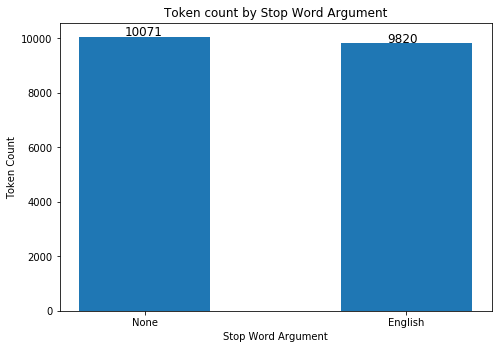

In [86]:
options = [None,'english']
token_counts = []
for option in options:
    t_dtm,t_df, t_vect = get_dtm_df(X,'title',stop_words = option)
    token_counts.append(t_dtm.shape[1])

fig = plt.figure()
plt.title('')
ax = fig.add_axes([0,0,1,1])
langs = ['None','English']
ax.bar(langs,token_counts,width=0.5)
ax.title.set_text('Token count by Stop Word Argument')
#ax.plot(min_dfs,token_counts)
ax.set_xlabel('Stop Word Argument')
ax.set_ylabel('Token Count')
for i in range(len(token_counts)):
    print()
    ax.text(x=i-0.075,y=token_counts[i]+20,s=token_counts[i],fontsize=12)
plt.show()

### Let's Take a look at  Minimum and Maximum Document Frequency parameters

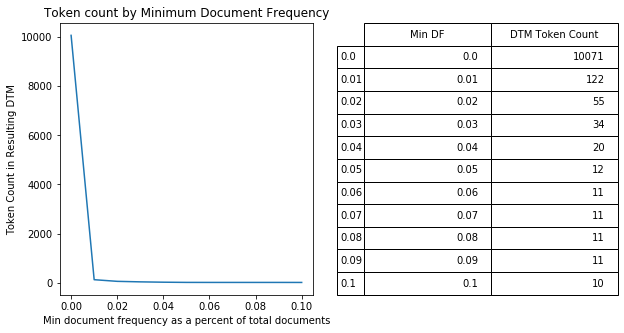

In [87]:
min_dfs = [each/100 for each in range(0,11,1)]
token_counts = []
for min_df in min_dfs:
    t_dtm,t_df, t_vect = get_dtm_df(X,'title',min_df = min_df)
    token_counts.append(t_dtm.shape[1])

fig = plt.figure(figsize=(10,5))    
ax1 = fig.add_subplot(121)
ax1.title.set_text('Token count by Minimum Document Frequency')
ax1.plot(min_dfs,token_counts)
ax1.set_xlabel('Min document frequency as a percent of total documents')
ax1.set_ylabel('Token Count in Resulting DTM')

ax2 = fig.add_subplot(122)
ax2.axis('off')

font_size=10
bbox=[0, 0, 1, 1]
tbl = ax2.table(cellText = list(zip(min_dfs,token_counts)), 
                bbox = bbox,
                rowLabels = min_dfs, 
                colLabels=['Min DF','DTM Token Count'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

plt.show()

### Looking at the percentage threshold for Minimum Document Frequency, a major drop off appears at 0.01 percent - or ~63 documents from our set of 6330 records.
- To get a more granular look at this 0% to 0.01% range, let's look at setting the min_df to an integer count of documents between 1 and 20.

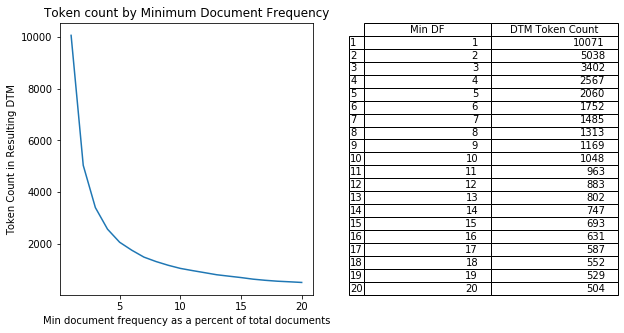

In [88]:
min_dfs = [each for each in range(1,21,1)]
token_counts = []
for min_df in min_dfs:
    t_dtm,t_df, t_vect = get_dtm_df(X,'title',min_df = min_df)
    token_counts.append(t_dtm.shape[1])

fig = plt.figure(figsize=(10,5))    
ax1 = fig.add_subplot(121)
ax1.title.set_text('Token count by Minimum Document Frequency')
ax1.plot(min_dfs,token_counts)
ax1.set_xlabel('Min document frequency as a percent of total documents')
ax1.set_ylabel('Token Count in Resulting DTM')

ax2 = fig.add_subplot(122)
ax2.axis('off')

font_size=10
bbox=[0, 0, 1, 1]
tbl = ax2.table(cellText = list(zip(min_dfs,token_counts)), 
                bbox = bbox,
                rowLabels = min_dfs, 
                colLabels=['Min DF','DTM Token Count'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

plt.show()

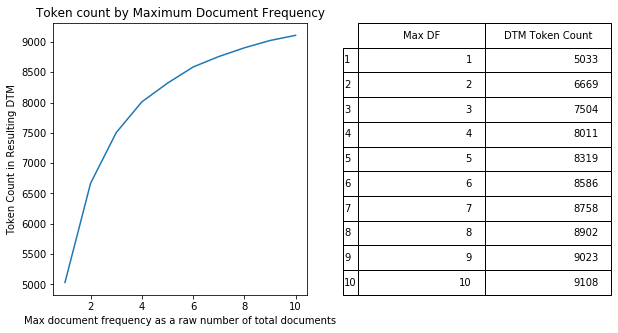

In [90]:
max_dfs = [each for each in range(1,11)]
token_counts = []
for max_df in max_dfs:
    t_dtm,t_df, t_vect = get_dtm_df(X,'title',max_df = max_df)
    token_counts.append(t_dtm.shape[1])

fig = plt.figure(figsize=(10,5))    
ax1 = fig.add_subplot(121)
ax1.title.set_text('Token count by Maximum Document Frequency')
ax1.plot(max_dfs,token_counts)
ax1.set_xlabel('Max document frequency as a raw number of total documents')
ax1.set_ylabel('Token Count in Resulting DTM')

ax2 = fig.add_subplot(122)
ax2.axis('off')

font_size=10
bbox=[0, 0, 1, 1]
tbl = ax2.table(cellText = list(zip(max_dfs,token_counts)), 
                bbox = bbox,
                rowLabels = max_dfs, 
                colLabels=['Max DF','DTM Token Count'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

plt.show()


# So which ones to adjust and how?  That depends on impact to the model.  
- Use Logistic Regression to demo with a common model used in dual target scenarios
- Of course, this isn't to say that Logistic Regression will perform better than other classifiers such as RF, NB, GBDT, SVC, etc... but it can be used as a guage
- Final tuning will come later 
- For this initial pass, given there is no class imbalance and there are only two classes in the target, check parameter adjustment impact on accuracy and ROC_AUC_SCORE/Curve
- Before tuning anything, check performance without adjusting any parameters

### Import Logistic Regression and Scoring modules
- For scoring, while there are a number of options that we'll consider later, for the purposes of assessing the impact of tuning the TFIDF Vectorizer parameters, we will use Accuracy.
- Accuracy in this case is simple to understand and is applicable since there are only 2 classes to predict and they are almost perectly balanced in the dataset.  
- Later on we will look at ROC, AUC, Precision, Recall and F1-Score as well when putting together a final model

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score

### Let's take a look at the impact of tuning the Vectorizer parameter 'Minimum Document Frequency'
- First we'll split out data into train/test sets for fitting and validating by the Logistic Regression model.
- We'll save both the average of the 3 fold cross-validated scores as well as the out of sample test score for each minimum df argument value
- In the next step we'll plot these values to see how the change in mininum document frequency impcats model complexity (as measured by the count of unique tokens in the resulting dtm) and the model's accuracy.

In [103]:
min_dfs = [each for each in range(1,21)]
token_counts = []
accuracy_scores = []
cv_scores = []
dtm_col = 'title'
y_col = 'Target'

for min_df in min_dfs:
    mdl = LogisticRegression()
    
    X_train,X_test,y_train,y_test = train_test_split(X,y['Target'], train_size=.8,random_state=random_state)
    train_dtm,train_df,vect = get_dtm_df(X_train,dtm_col,min_df = min_df)
    token_counts.append(train_dtm.shape[1])
    
    # Mean Test Error on 3-Fold Cross Validation of Training Data
    cv_scores.append(cross_val_score(mdl,train_dtm,y_train,cv=3).mean())
    
    
    mdl.fit(train_dtm, y_train)
    test_dtm = vect.transform(X_test[dtm_col])
    y_hat = mdl.predict(test_dtm)
    
    # Out of Sample Error
    accuracy_scores.append(accuracy_score(y_test,y_hat))

### Plot the change in overall Token Count of the DTM along with the associated delta in model accuracy from adjusting the Minimum Document Frequency
- Minimum document frequency tells the vectorizer to ignore terms that appear in less than the X number of documents.  In our case, it will be ignoring tokens that appear in less than 20 documents all the way to less than 2 documents.  When Min_DF is set to 1, the vectorizer doesn't ignore any terms.
- We see that the simply increasing the minimum df to 2 documnents, results in reducing the DTM size by 50% to ~4300 tokens - and it does this without any impact to model accuracy of 82%! 
- The further we increase the minimum df value, the more we see model accuracy does eventually decrease.  
- However, it is worth noting that in absolute terms, increasing the minimimum df from the low of 1 to the high of 20  only results in the model dropping 6% in absolute terms of accuracy, with a dtm comprised of just a little under 400 tokens.  
- We will use the information from this analysis to set the Minimum Document Frequncy arguments to the range of 1 - 6 in our upcoming GridSearch

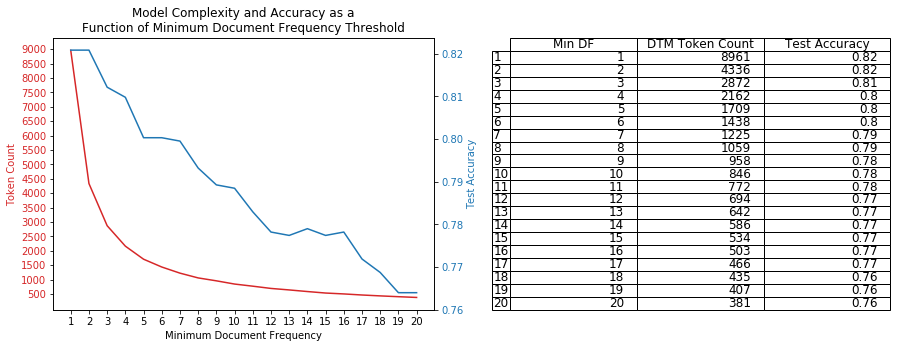

In [113]:
plt.gcf().set_size_inches(15, 5)
#fig.suptitle('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
color = 'tab:red'

# Token Count per iterable of selected Vect Parameter Argument
ax1.set_title('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')
ax1.set_xlabel('Minimum Document Frequency')
ax1.set_ylabel('Token Count', color=color)
ax1.set_xticks(min_dfs)
ax1.set_yticks(range(500,10001,500))
ax1.plot(min_dfs, token_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Test Accuracy
color = 'tab:blue'
ax2.plot(min_dfs, accuracy_scores, color=color)
#ax2.plot(min_dfs, cv_scores, color=color)
ax2.set_ylabel('Test Accuracy', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(list(set([int(each*100)/100 for each in accuracy_scores])))

# Table
ax3.axis('off')
font_size=12
bbox=[0, 0, 1, 1]
tbl = ax3.table(cellText = list(zip(min_dfs,token_counts,list(([int(each*100)/100 for each in accuracy_scores])))), 
                bbox = bbox,
                rowLabels = min_dfs, 
                colLabels=['Min DF','DTM Token Count','Test Accuracy'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


### Let's repeath the process for Maximum DF

In [118]:
max_dfs = [each for each in range(1,21)]
token_counts = []
accuracy_scores = []
cv_scores = []
dtm_col = 'title'
y_col = 'Target'

for max_df in max_dfs:
    mdl = LogisticRegression()
    
    X_train,X_test,y_train,y_test = train_test_split(X,y['Target'], train_size=.8,random_state=random_state)
    train_dtm,train_df,vect = get_dtm_df(X_train,dtm_col,max_df = max_df)
    token_counts.append(train_dtm.shape[1])
    
    # Mean Test Error on 3-Fold Cross Validation of Training Data
    cv_scores.append(cross_val_score(mdl,train_dtm,y_train,cv=3).mean())
    
    
    mdl.fit(train_dtm, y_train)
    test_dtm = vect.transform(X_test[dtm_col])
    y_hat = mdl.predict(test_dtm)
    
    # Out of Sample Error
    accuracy_scores.append(accuracy_score(y_test,y_hat))

### And plot the results for Token Counts and Model Accuracy
- We see with a Max DF of 1, (ie, with the vectorizer removing tokens that appear in more than 1 document) that there are 4625 tokens that only appear in a single title!  Unsurprisingly, the model only achieves slightly better (58% accuracy) than our baseline accuracy of 50% when removing tokens that appear in more than 1 document.
- At the other end of the spectrum we've analyzed, with a Max DF of 20, the model still only attains 71% accuracy
- This analyis demonstrates that in order to create a better decision boundary between FAKE and REAL titles, the model needs tokens that appear in more than a small subset documents.  I
- Limiting the Maximum DF beyond 20 documents will have minimal impact on the overall complexity of the model while still adversely impacting the 

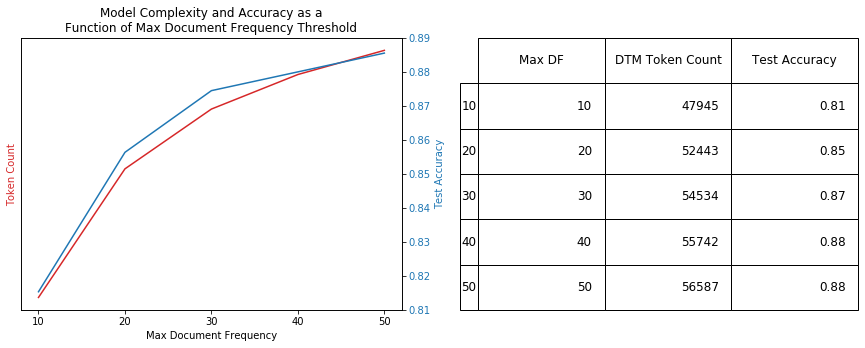

In [147]:
plt.gcf().set_size_inches(15, 5)
#fig.suptitle('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
color = 'tab:red'

# Token Count per iterable of selected Vect Parameter Argument
ax1.set_title('Model Complexity and Accuracy as a\nFunction of Max Document Frequency Threshold')
ax1.set_xlabel('Max Document Frequency')
ax1.set_ylabel('Token Count', color=color)
ax1.set_xticks(max_dfs)
ax1.set_yticks(range(500,10001,500))
ax1.plot(max_dfs, token_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Test Accuracy
color = 'tab:blue'
ax2.plot(max_dfs, accuracy_scores, color=color)
#ax2.plot(min_dfs, cv_scores, color=color)
ax2.set_ylabel('Test Accuracy', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yticks(list(set([int(each*100)/100 for each in accuracy_scores])))
acc_clean = list(set([int(each*100)/100 for each in accuracy_scores]))     
ax2.set_ylim([min(acc_clean),max(acc_clean)+.01])

# Table
ax3.axis('off')
font_size=12
bbox=[0, 0, 1, 1]
tbl = ax3.table(cellText = list(zip(max_dfs,token_counts,list(([int(each*100)/100 for each in accuracy_scores])))), 
                bbox = bbox,
                rowLabels = max_dfs, 
                colLabels=['Max DF','DTM Token Count','Test Accuracy'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Text Min DF
- The model is able to glean the necessary information from a much smaller subset of tokens than those provided in the entire set.
- Even with a Min DF of 20, the model still has an average Validation score of 90.5%
- 

In [149]:
min_dfs = [each for each in range(1,21)]
token_counts = []
accuracy_scores = []
cv_scores = []
dtm_col = 'text'
y_col = 'Target'

i = 1
for min_df in min_dfs:
    print(i)
    mdl = LogisticRegression()
    
    X_train,X_test,y_train,y_test = train_test_split(X,y['Target'], train_size=.8,random_state=random_state)
    train_dtm,train_df,vect = get_dtm_df(X_train,dtm_col,min_df = min_df)
    token_counts.append(train_dtm.shape[1])
    
    # Mean Test Error on 3-Fold Cross Validation of Training Data
    cv_scores.append(cross_val_score(mdl,train_dtm,y_train,cv=3).mean())
    
    
    mdl.fit(train_dtm, y_train)
    test_dtm = vect.transform(X_test[dtm_col])
    y_hat = mdl.predict(test_dtm)
    
    # Out of Sample Error
    accuracy_scores.append(accuracy_score(y_test,y_hat))
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


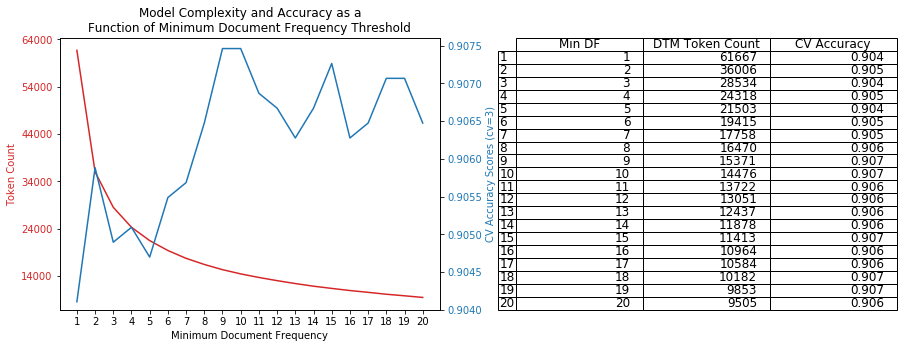

In [151]:
plt.gcf().set_size_inches(15, 5)
#fig.suptitle('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
color = 'tab:red'

# Token Count per iterable of selected Vect Parameter Argument
ax1.set_title('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')
ax1.set_xlabel('Minimum Document Frequency')
ax1.set_ylabel('Token Count', color=color)
ax1.set_xticks(min_dfs)
ax1.set_yticks(range(14000,64001,10000))
ax1.plot(min_dfs, token_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Test Accuracy
color = 'tab:blue'
ax2.plot(min_dfs, cv_scores, color=color)
#ax2.plot(min_dfs, cv_scores, color=color)
ax2.set_ylabel('CV Accuracy Scores (cv=3)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yticks(list(set([int(each*10000)/10000 for each in cv_scores])))
ax2.set_ylim([0.9040, 0.9076])

# Table
ax3.axis('off')
font_size=12
bbox=[0, 0, 1, 1]
tbl = ax3.table(cellText = list(zip(min_dfs,token_counts,list(([int(each*1000)/1000 for each in cv_scores])))), 
                bbox = bbox,
                rowLabels = min_dfs, 
                colLabels=['Min DF','DTM Token Count','CV Accuracy'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [155]:
min_dfs = [each for each in range(20,101,20)]
token_counts = []
accuracy_scores = []
cv_scores = []
dtm_col = 'text'
y_col = 'Target'

i = 1
for min_df in min_dfs:
    print(i)
    mdl = LogisticRegression()
    
    X_train,X_test,y_train,y_test = train_test_split(X,y['Target'], train_size=.8,random_state=random_state)
    train_dtm,train_df,vect = get_dtm_df(X_train,dtm_col,min_df = min_df)
    token_counts.append(train_dtm.shape[1])
    
    # Mean Test Error on 3-Fold Cross Validation of Training Data
    cv_scores.append(cross_val_score(mdl,train_dtm,y_train,cv=3).mean())
    
    
    mdl.fit(train_dtm, y_train)
    test_dtm = vect.transform(X_test[dtm_col])
    y_hat = mdl.predict(test_dtm)
    
    # Out of Sample Error
    accuracy_scores.append(accuracy_score(y_test,y_hat))
    i+=1

1
2
3
4
5


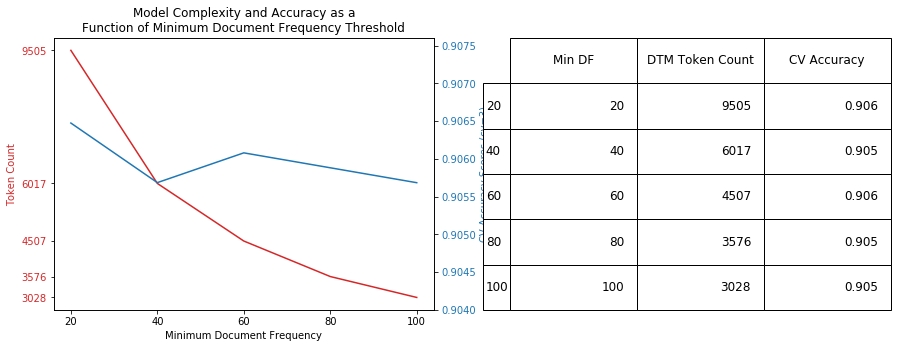

In [156]:
plt.gcf().set_size_inches(15, 5)
#fig.suptitle('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
color = 'tab:red'

# Token Count per iterable of selected Vect Parameter Argument
ax1.set_title('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')
ax1.set_xlabel('Minimum Document Frequency')
ax1.set_ylabel('Token Count', color=color)
ax1.set_xticks(min_dfs)
ax1.set_yticks(token_counts)
ax1.plot(min_dfs, token_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Test Accuracy
color = 'tab:blue'
ax2.plot(min_dfs, cv_scores, color=color)
#ax2.plot(min_dfs, cv_scores, color=color)
ax2.set_ylabel('CV Accuracy Scores (cv=3)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yticks(list(set([int(each*10000)/10000 for each in cv_scores])))
ax2.set_ylim([0.9040, 0.9076])

# Table
ax3.axis('off')
font_size=12
bbox=[0, 0, 1, 1]
tbl = ax3.table(cellText = list(zip(min_dfs,token_counts,list(([int(each*1000)/1000 for each in cv_scores])))), 
                bbox = bbox,
                rowLabels = min_dfs, 
                colLabels=['Min DF','DTM Token Count','CV Accuracy'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Text Max DF

In [145]:
max_dfs = [each for each in range(10,51,10)]
token_counts = []
accuracy_scores = []
cv_scores = []
dtm_col = 'text'
y_col = 'Target'

i = 1
for max_df in max_dfs:
    print(i)
    mdl = LogisticRegression()
    
    X_train,X_test,y_train,y_test = train_test_split(X,y['Target'], train_size=.8,random_state=random_state)
    train_dtm,train_df,vect = get_dtm_df(X_train,dtm_col,max_df = max_df)
    token_counts.append(train_dtm.shape[1])
    
    # Mean Test Error on 3-Fold Cross Validation of Training Data
    cv_scores.append(cross_val_score(mdl,train_dtm,y_train,cv=3).mean())
    
    
    mdl.fit(train_dtm, y_train)
    test_dtm = vect.transform(X_test[dtm_col])
    y_hat = mdl.predict(test_dtm)
    
    # Out of Sample Error
    accuracy_scores.append(accuracy_score(y_test,y_hat))
    i+=1

1
2
3
4
5


### We see that the trade-off between complexity and accuracy isn't reflected by adjusting the Max DF arguments like it was with Min DF.  
- With this information, I will exclude the Max DF parameter from the GridSearch analysis.

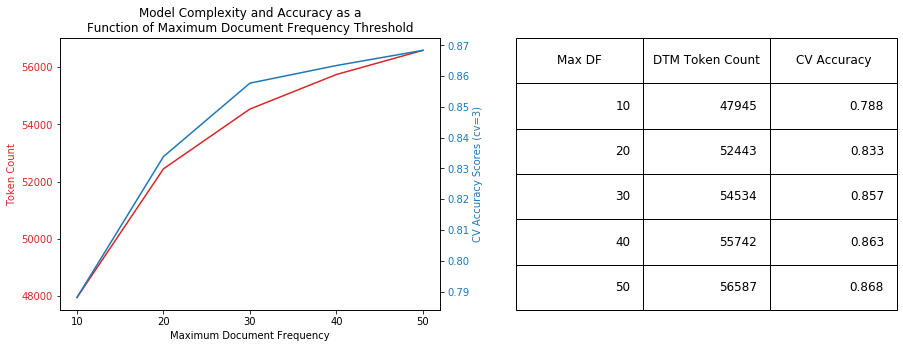

In [146]:
plt.gcf().set_size_inches(15, 5)
#fig.suptitle('Model Complexity and Accuracy as a\nFunction of Minimum Document Frequency Threshold')

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
color = 'tab:red'

# Token Count per iterable of selected Vect Parameter Argument
ax1.set_title('Model Complexity and Accuracy as a\nFunction of Maximum Document Frequency Threshold')
ax1.set_xlabel('Maximum Document Frequency')
ax1.set_ylabel('Token Count', color=color)
ax1.set_xticks(max_dfs)
#ax1.set_yticks(range(50000,60001,1000))
ax1.plot(max_dfs, token_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Test Accuracy
color = 'tab:blue'
ax2.plot(max_dfs, cv_scores, color=color)
#ax2.plot(min_dfs, cv_scores, color=color)
ax2.set_ylabel('CV Accuracy Scores (cv=3)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yticks(list(set([int(each*10000)/10000 for each in cv_scores])))
#ax2.set_ylim([0.9040, 0.9076])

# Table
ax3.axis('off')
font_size=12
bbox=[0, 0, 1, 1]
tbl = ax3.table(cellText = list(zip(max_dfs,token_counts,list(([int(each*1000)/1000 for each in cv_scores])))), 
                bbox = bbox,
                #rowLabels = max_dfs, 
                colLabels=['Max DF','DTM Token Count','CV Accuracy'])

tbl.auto_set_font_size(False)
tbl.set_fontsize(font_size)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# GridSearch vs RandomSearch
### So, looking at each element, how to incorporate all at once?  GridSearch and Randomized Search.
- I will perform the GridSearch twice: once for the Title feature DTM and once for the Text feature DTM

In [168]:
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.pipeline import Pipeline

### Tune the Tfidf Vect Parameters for the Title Column
- NB: Pipeline will convert the X_train data from it's raw format to the DTM using the Tfidf vectorizer pass in

In [219]:
x_cols = 'title'
y_target = 'Target'
X_train,X_test,y_train,y_test = train_test_split(df[x_cols],y[y_target], train_size=.8,random_state=random_state)

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__min_df': range(3,7),
    'vect__norm':['l1','l2'],
    'vect__stop_words':[None,'english'],
    'clf__penalty':['l1', 'l2', 'elasticnet'],
    'clf__C':[.01,.1,1],
    'clf__solver':['lbfgs', 'liblinear']
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3,verbose=1)
grid_search_tune.fit(X_train, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solv

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [220]:
print('Best Estimator: {}\nBest Score:{}'.format(grid_search_tune.best_estimator_,grid_search_tune.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True,

In [221]:
grid_results = grid_search_tune.cv_results_
grid_results_df = pd.DataFrame.from_dict(grid_results)

In [224]:
grid_results_df.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_clf__solver,param_vect__min_df,param_vect__ngram_range,param_vect__norm,param_vect__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
455,0.144077,0.009514,0.032472,0.001451,1,l2,lbfgs,3,"(1, 2)",l2,english,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.801775,0.819420,0.800474,0.807223,0.008641,1
487,0.116258,0.001550,0.031576,0.000576,1,l2,liblinear,3,"(1, 2)",l2,english,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.801775,0.819420,0.799882,0.807026,0.008798,2
482,0.056995,0.000326,0.021171,0.000194,1,l2,liblinear,3,"(1, 1)",l2,None,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.807692,0.808171,0.803434,0.806432,0.002129,3
450,0.073367,0.001240,0.021484,0.000506,1,l2,lbfgs,3,"(1, 1)",l2,None,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.807692,0.808171,0.803434,0.806432,0.002129,3
454,0.173798,0.003309,0.038262,0.001573,1,l2,lbfgs,3,"(1, 2)",l2,None,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.814201,0.804026,0.801066,0.806431,0.005626,5


In [248]:
prams = {}
prams['title'] = grid_search_tune.best_estimator_['vect']

## Store Results to Database
- We need to convert both the ngram_range of tuples and the params dictionary to strings in order to store them in our database as TEXT.

In [225]:
import sqlite3
db_name = 'fake_news.db'
db_pth = '../data/'

cn = sqlite3.connect(os.path.join(db_pth,db_name))

In [230]:
grid_results_df['param_vect__ngram_range'] = grid_results_df['param_vect__ngram_range'].apply(lambda x: str(x))
grid_results_df = grid_results_df.drop('params',axis=1)

In [231]:
grid_results_df.to_sql('t_Title_Vect_Logit_GSCV',cn,index=False,if_exists='replace')

# Perform Same on Text

In [232]:
x_cols = 'text'
y_target = 'Target'
X_train,X_test,y_train,y_test = train_test_split(df[x_cols],y[y_target], train_size=.8,random_state=random_state)

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__min_df': range(50,251,50),
    'vect__norm':['l1','l2'],
    'vect__stop_words':[None,'english'],
    'clf__penalty':['l1', 'l2', 'elasticnet'],
    'clf__C':[.01,.1,1],
    'clf__solver':['lbfgs', 'liblinear']
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3,verbose=1)
grid_search_tune.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solv

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [233]:
print('Best Estimator: {}\nBest Score:{}'.format(grid_search_tune.best_estimator_,grid_search_tune.best_score_))

Best Estimator: Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=50, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True

In [250]:
prams['text'] = grid_search_tune.best_estimator_['vect']

In [244]:
text_grid_results = grid_search_tune.cv_results_
text_grid_results_df = pd.DataFrame.from_dict(text_grid_results)

In [245]:
text_grid_results_df['param_vect__ngram_range'] = text_grid_results_df['param_vect__ngram_range'].apply(lambda x: str(x))
text_grid_results_df['params'] = text_grid_results_df['params'].apply(lambda x: str(x))

In [246]:
text_grid_results_df.to_sql('t_Text_Vect_Logit_GSCV',cn,index=False,if_exists='replace')

# Apply optimized Vectorizer to Different Classifiers
- ROC Curve Here.
- Bring in Combined
- Talk about predict, proba

In [265]:
from sklearn.metrics import f1_score, roc_auc_score, auc, roc_curve, precision_recall_fscore_support, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [272]:
def plotROCCurve(y_actual,y_hat,clf_name):
    ''' Plot the ROC Curve for the Given Classifier'''
    fpr, tpr, threshold = roc_curve(y_actual, y_hat)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve: {}'.format(clf_name))
    print('Area Under the Curve: {:.2f}'.format(auc(fpr, tpr)))
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()

In [259]:
clfs = [LogisticRegression(random_state=random_state),
        KNeighborsClassifier(),
        SVC(probability=True,random_state=random_state), # set probability in order to access predict proba method
        MultinomialNB(),
        AdaBoostClassifier(random_state=random_state),
        GradientBoostingClassifier(random_state=random_state),
        RandomForestClassifier(random_state=random_state)]

models = {clf.__class__.__name__:clf for clf in clfs}



## Try the Optimized Vectorizer on a few different Models
- Start with Title
- See if adding in Count of Uppercase Words Helps

In [263]:
dtm_col = 'title'
X_train, X_test, y_train, y_test = train_test_split(X,y[y_col])
vect_title = prams[dtm_col]
X_train_dtm = vect_title.fit_transform(X_train[dtm_col])
X_test_dtm = vect_title.transform(X_test[dtm_col])


Model: LogisticRegression
Area Under the Curve: 0.88


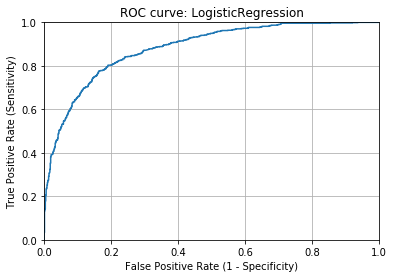

	ROC AUC SCORE: 0.80
	F1 Score: 0.79

Classification Report - LogisticRegression
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       812
           1       0.81      0.78      0.79       772

    accuracy                           0.80      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.80      0.80      0.80      1584




Model: KNeighborsClassifier
Area Under the Curve: 0.64


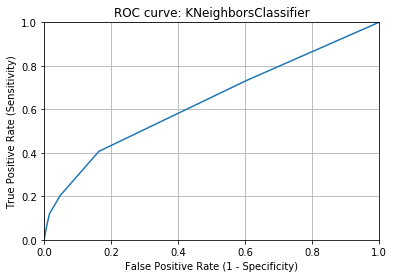

	ROC AUC SCORE: 0.58
	F1 Score: 0.32

Classification Report - KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.56      0.95      0.70       812
           1       0.80      0.20      0.32       772

    accuracy                           0.59      1584
   macro avg       0.68      0.58      0.51      1584
weighted avg       0.68      0.59      0.52      1584




Model: SVC
Area Under the Curve: 0.89


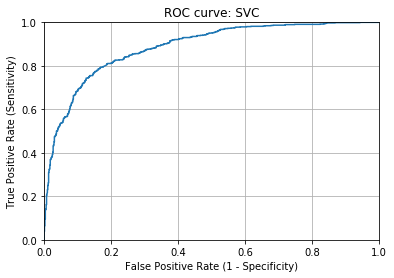

	ROC AUC SCORE: 0.81
	F1 Score: 0.80

Classification Report - SVC
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       812
           1       0.82      0.79      0.80       772

    accuracy                           0.81      1584
   macro avg       0.81      0.81      0.81      1584
weighted avg       0.81      0.81      0.81      1584




Model: MultinomialNB
Area Under the Curve: 0.88


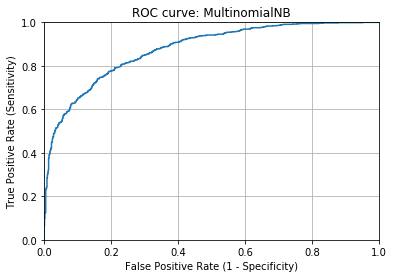

	ROC AUC SCORE: 0.79
	F1 Score: 0.79

Classification Report - MultinomialNB
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       812
           1       0.77      0.81      0.79       772

    accuracy                           0.79      1584
   macro avg       0.79      0.79      0.79      1584
weighted avg       0.79      0.79      0.79      1584




Model: AdaBoostClassifier
Area Under the Curve: 0.79


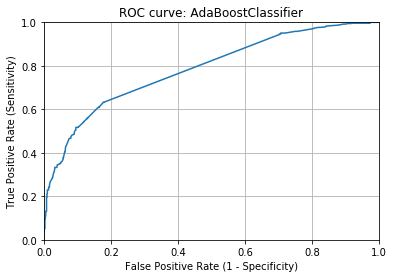

	ROC AUC SCORE: 0.72
	F1 Score: 0.66

Classification Report - AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       812
           1       0.80      0.56      0.66       772

    accuracy                           0.72      1584
   macro avg       0.74      0.72      0.71      1584
weighted avg       0.74      0.72      0.71      1584




Model: GradientBoostingClassifier
Area Under the Curve: 0.82


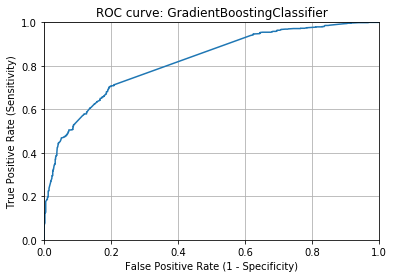

	ROC AUC SCORE: 0.74
	F1 Score: 0.70

Classification Report - GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       812
           1       0.80      0.63      0.70       772

    accuracy                           0.74      1584
   macro avg       0.75      0.74      0.74      1584
weighted avg       0.75      0.74      0.74      1584




Model: RandomForestClassifier
Area Under the Curve: 0.88


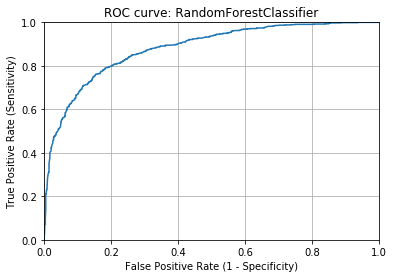

	ROC AUC SCORE: 0.80
	F1 Score: 0.80

Classification Report - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       812
           1       0.80      0.79      0.80       772

    accuracy                           0.80      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.80      0.80      0.80      1584






In [274]:
test_results = {}
cv_results = {}

for name,mdl in models.items():
    print('Model: {}'.format(name))
    mdl.fit(X_train_dtm, y_train)
    
    y_hat_proba = mdl.predict_proba(X_test_dtm)[:,1]
    plotROCCurve(y_test,y_hat_proba,name)
    y_hat = mdl.predict(X_test_dtm)
    print('\tROC AUC SCORE: {:.2f}'.format(roc_auc_score(y_test,y_hat)))
    test_results[name] = {'ROC_AUC':'{:.2f}'.format(roc_auc_score(y_test,y_hat))}
    print('\tF1 Score: {:.2f}\n'.format(f1_score(y_test,y_hat)))
    test_results[name].update({'F1_Score':'{:.2f}'.format(f1_score(y_test,y_hat))})
    print('Classification Report - {}\n{}'.format(name, classification_report(y_test,y_hat)))
    report = classification_report(y_test, y_hat,output_dict=True)
    test_results[name].update({'accuracy':str('{:.2f}'.format(report['accuracy']))})
    test_results[name].update({k:str('{:.2f}'.format(v)) for k,v in report['macro avg'].items()})
    print('\n\n')

# Repeat for Text

In [280]:
dtm_col = 'text'
X_train, X_test, y_train, y_test = train_test_split(X,y[y_col])
#vect = prams[dtm_col]
vect = TfidfVectorizer()
X_train_dtm = vect.fit_transform(X_train[dtm_col])
X_test_dtm = vect.transform(X_test[dtm_col])


Model: LogisticRegression
Area Under the Curve: 0.98


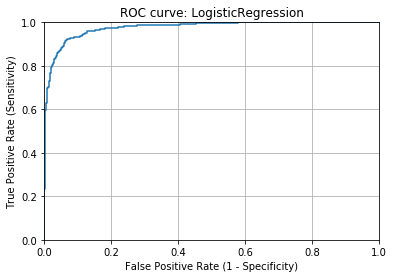

	ROC AUC SCORE: 0.92
	F1 Score: 0.92

Classification Report - LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       787
           1       0.94      0.91      0.92       797

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584




Model: KNeighborsClassifier
Area Under the Curve: 0.73


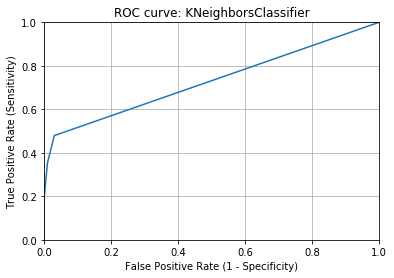

	ROC AUC SCORE: 0.63
	F1 Score: 0.43

Classification Report - KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.57      0.99      0.73       787
           1       0.98      0.27      0.43       797

    accuracy                           0.63      1584
   macro avg       0.78      0.63      0.58      1584
weighted avg       0.78      0.63      0.58      1584




Model: SVC
Area Under the Curve: 0.98


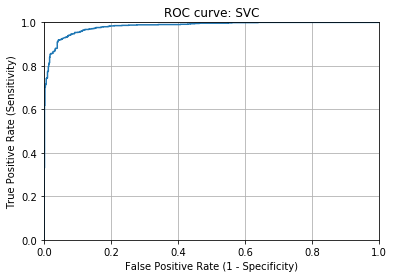

	ROC AUC SCORE: 0.94
	F1 Score: 0.93

Classification Report - SVC
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       787
           1       0.95      0.92      0.93       797

    accuracy                           0.93      1584
   macro avg       0.94      0.94      0.93      1584
weighted avg       0.94      0.93      0.93      1584




Model: MultinomialNB
Area Under the Curve: 0.95


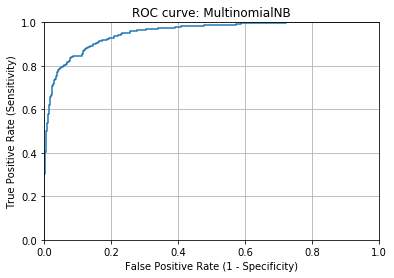

	ROC AUC SCORE: 0.88
	F1 Score: 0.87

Classification Report - MultinomialNB
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       787
           1       0.90      0.85      0.87       797

    accuracy                           0.88      1584
   macro avg       0.88      0.88      0.88      1584
weighted avg       0.88      0.88      0.88      1584




Model: AdaBoostClassifier
Area Under the Curve: 0.95


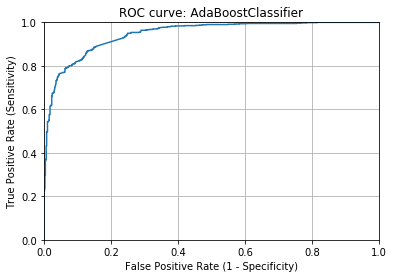

	ROC AUC SCORE: 0.86
	F1 Score: 0.86

Classification Report - AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       787
           1       0.88      0.84      0.86       797

    accuracy                           0.86      1584
   macro avg       0.86      0.86      0.86      1584
weighted avg       0.86      0.86      0.86      1584




Model: GradientBoostingClassifier
Area Under the Curve: 0.96


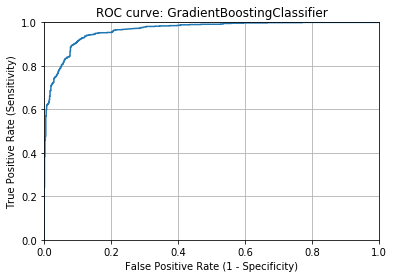

	ROC AUC SCORE: 0.91
	F1 Score: 0.90

Classification Report - GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       787
           1       0.92      0.89      0.90       797

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584




Model: RandomForestClassifier
Area Under the Curve: 0.97


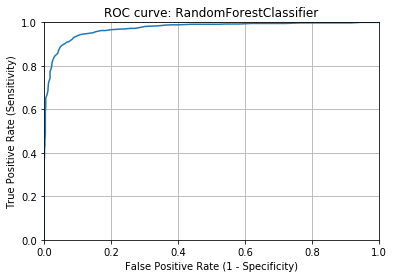

	ROC AUC SCORE: 0.92
	F1 Score: 0.92

Classification Report - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       787
           1       0.93      0.91      0.92       797

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584






In [278]:
test_results = {}
cv_results = {}

for name,mdl in models.items():
    print('Model: {}'.format(name))
    mdl.fit(X_train_dtm, y_train)
    
    y_hat_proba = mdl.predict_proba(X_test_dtm)[:,1]
    plotROCCurve(y_test,y_hat_proba,name)
    y_hat = mdl.predict(X_test_dtm)
    print('\tROC AUC SCORE: {:.2f}'.format(roc_auc_score(y_test,y_hat)))
    test_results[name] = {'ROC_AUC':'{:.2f}'.format(roc_auc_score(y_test,y_hat))}
    print('\tF1 Score: {:.2f}\n'.format(f1_score(y_test,y_hat)))
    test_results[name].update({'F1_Score':'{:.2f}'.format(f1_score(y_test,y_hat))})
    print('Classification Report - {}\n{}'.format(name, classification_report(y_test,y_hat)))
    report = classification_report(y_test, y_hat,output_dict=True)
    test_results[name].update({'accuracy':str('{:.2f}'.format(report['accuracy']))})
    test_results[name].update({k:str('{:.2f}'.format(v)) for k,v in report['macro avg'].items()})
    print('\n\n')

## See if model performance can be improved by adding in Count of Uppercase Words

In [292]:
X['TITLE_UPPER_CNT_2'] = np.array(['UPPER_CNT_']) + df['TITLE_UPPER_CNT_2'].astype(str)
X['title_2'] = X['title'] + ' ' + X['TITLE_UPPER_CNT_2']
X['title_2']

0                You Can Smell Hillary’s Fear UPPER_CNT_0
1       Watch The Exact Moment Paul Ryan Committed Pol...
2       Kerry to go to Paris in gesture of sympathy UP...
3       Bernie supporters on Twitter erupt in anger ag...
4       The Battle of New York: Why This Primary Matte...
                              ...                        
6330    State Department says it can't find emails fro...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332    Anti-Trump Protesters Are Tools of the Oligarc...
6333    In Ethiopia, Obama seeks progress on peace, se...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: title_2, Length: 6335, dtype: object

Model: LogisticRegression
Area Under the Curve: 0.89


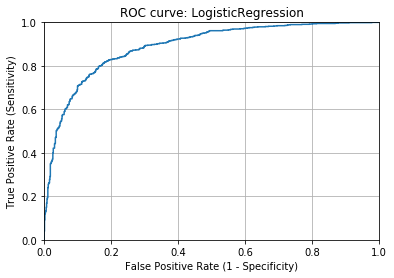

	ROC AUC SCORE: 0.82
	F1 Score: 0.81

Classification Report - LogisticRegression
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       801
           1       0.82      0.81      0.81       783

    accuracy                           0.82      1584
   macro avg       0.82      0.82      0.82      1584
weighted avg       0.82      0.82      0.82      1584




Model: KNeighborsClassifier
Area Under the Curve: 0.81


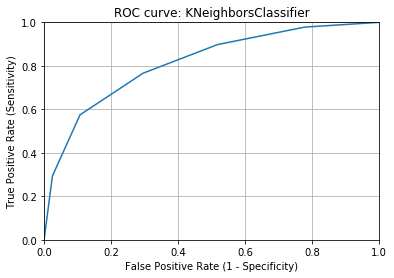

	ROC AUC SCORE: 0.74
	F1 Score: 0.74

Classification Report - KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       801
           1       0.72      0.77      0.74       783

    accuracy                           0.73      1584
   macro avg       0.74      0.74      0.73      1584
weighted avg       0.74      0.73      0.73      1584




Model: SVC
Area Under the Curve: 0.89


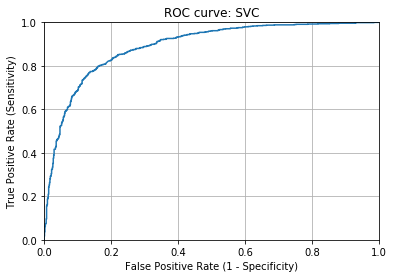

	ROC AUC SCORE: 0.81
	F1 Score: 0.81

Classification Report - SVC
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       801
           1       0.82      0.80      0.81       783

    accuracy                           0.81      1584
   macro avg       0.81      0.81      0.81      1584
weighted avg       0.81      0.81      0.81      1584




Model: MultinomialNB
Area Under the Curve: 0.89


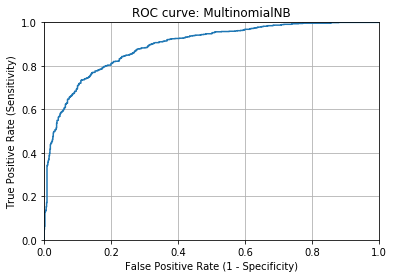

	ROC AUC SCORE: 0.80
	F1 Score: 0.80

Classification Report - MultinomialNB
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       801
           1       0.78      0.82      0.80       783

    accuracy                           0.80      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.80      0.80      0.80      1584




Model: AdaBoostClassifier
Area Under the Curve: 0.81


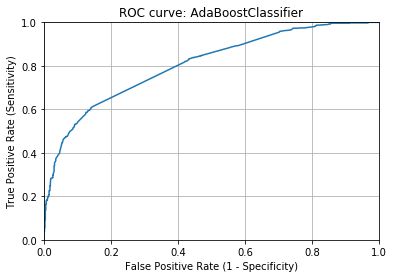

	ROC AUC SCORE: 0.73
	F1 Score: 0.69

Classification Report - AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.69      0.86      0.77       801
           1       0.81      0.60      0.69       783

    accuracy                           0.73      1584
   macro avg       0.75      0.73      0.73      1584
weighted avg       0.75      0.73      0.73      1584




Model: GradientBoostingClassifier
Area Under the Curve: 0.82


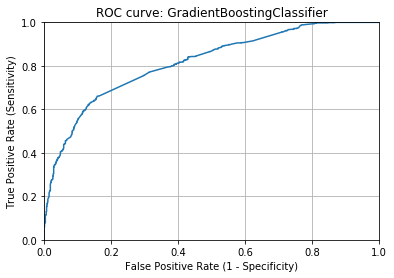

	ROC AUC SCORE: 0.75
	F1 Score: 0.72

Classification Report - GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       801
           1       0.80      0.66      0.72       783

    accuracy                           0.75      1584
   macro avg       0.76      0.75      0.75      1584
weighted avg       0.76      0.75      0.75      1584




Model: RandomForestClassifier
Area Under the Curve: 0.87


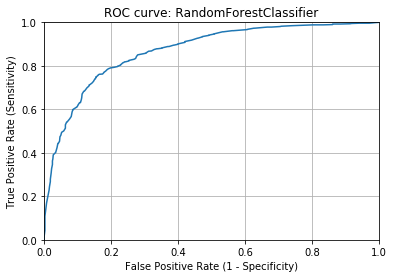

	ROC AUC SCORE: 0.80
	F1 Score: 0.79

Classification Report - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       801
           1       0.82      0.76      0.79       783

    accuracy                           0.80      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.80      0.80      0.80      1584






In [294]:
dtm_col = 'title_2'
X_train, X_test, y_train, y_test = train_test_split(X,y[y_col])
vect_title = prams['title']
X_train_dtm = vect_title.fit_transform(X_train[dtm_col])
X_test_dtm = vect_title.transform(X_test[dtm_col])

test_results = {}
cv_results = {}

for name,mdl in models.items():
    print('Model: {}'.format(name))
    mdl.fit(X_train_dtm, y_train)
    
    y_hat_proba = mdl.predict_proba(X_test_dtm)[:,1]
    plotROCCurve(y_test,y_hat_proba,name)
    y_hat = mdl.predict(X_test_dtm)
    print('\tROC AUC SCORE: {:.2f}'.format(roc_auc_score(y_test,y_hat)))
    test_results[name] = {'ROC_AUC':'{:.2f}'.format(roc_auc_score(y_test,y_hat))}
    print('\tF1 Score: {:.2f}\n'.format(f1_score(y_test,y_hat)))
    test_results[name].update({'F1_Score':'{:.2f}'.format(f1_score(y_test,y_hat))})
    print('Classification Report - {}\n{}'.format(name, classification_report(y_test,y_hat)))
    report = classification_report(y_test, y_hat,output_dict=True)
    test_results[name].update({'accuracy':str('{:.2f}'.format(report['accuracy']))})
    test_results[name].update({k:str('{:.2f}'.format(v)) for k,v in report['macro avg'].items()})
    print('\n\n')

# Ensemble the Optimzed Title and Text SVC models

In [297]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

In [298]:
#X['TITLE_UPPER_CNT_2'] = np.array(['UPPER_CNT_']) + df['TITLE_UPPER_CNT_2'].astype(str)
X['text_2'] = X['text'] + ' ' + X['TITLE_UPPER_CNT_2']
X['text_2']

0       Daniel Greenfield, a Shillman Journalism Fello...
1       Google Pinterest Digg Linkedin Reddit Stumbleu...
2       U.S. Secretary of State John F. Kerry said Mon...
3       — Kaydee King (@KaydeeKing) November 9, 2016 T...
4       It's primary day in New York and front-runners...
                              ...                        
6330    The State Department told the Republican Natio...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332     Anti-Trump Protesters Are Tools of the Oligar...
6333    ADDIS ABABA, Ethiopia —President Obama convene...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: text_2, Length: 6335, dtype: object

Area Under the Curve: 0.96


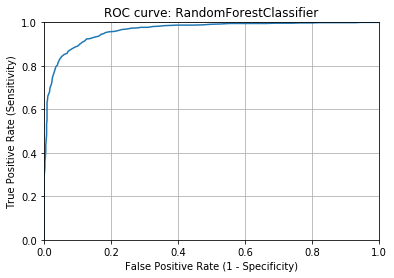

Model: LogisticRegression
Area Under the Curve: 0.97


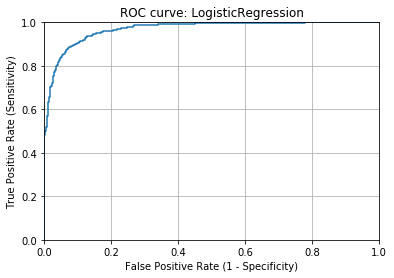

	ROC AUC SCORE: 0.90
	F1 Score: 0.90

Classification Report - LogisticRegression
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       796
           1       0.91      0.90      0.90       788

    accuracy                           0.90      1584
   macro avg       0.90      0.90      0.90      1584
weighted avg       0.90      0.90      0.90      1584




Model: KNeighborsClassifier
Area Under the Curve: 0.91


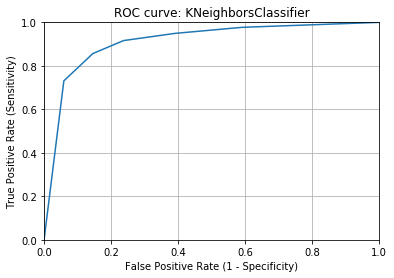

	ROC AUC SCORE: 0.84
	F1 Score: 0.85

Classification Report - KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.90      0.76      0.83       796
           1       0.79      0.92      0.85       788

    accuracy                           0.84      1584
   macro avg       0.85      0.84      0.84      1584
weighted avg       0.85      0.84      0.84      1584




Model: SVC
Area Under the Curve: 0.98


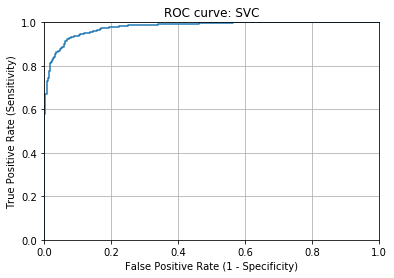

	ROC AUC SCORE: 0.92
	F1 Score: 0.92

Classification Report - SVC
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       796
           1       0.93      0.91      0.92       788

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584




Model: MultinomialNB
Area Under the Curve: 0.94


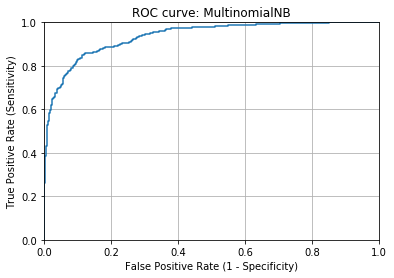

	ROC AUC SCORE: 0.87
	F1 Score: 0.86

Classification Report - MultinomialNB
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       796
           1       0.88      0.85      0.86       788

    accuracy                           0.87      1584
   macro avg       0.87      0.87      0.87      1584
weighted avg       0.87      0.87      0.87      1584




Model: AdaBoostClassifier
Area Under the Curve: 0.95


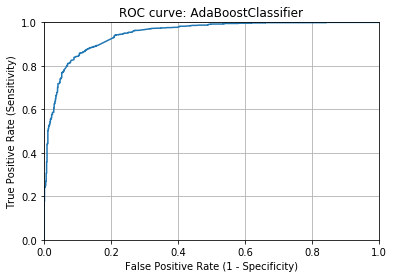

	ROC AUC SCORE: 0.87
	F1 Score: 0.87

Classification Report - AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       796
           1       0.88      0.87      0.87       788

    accuracy                           0.87      1584
   macro avg       0.87      0.87      0.87      1584
weighted avg       0.87      0.87      0.87      1584




Model: GradientBoostingClassifier
Area Under the Curve: 0.96


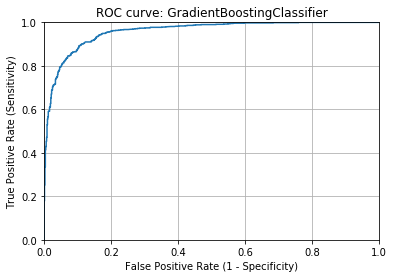

	ROC AUC SCORE: 0.89
	F1 Score: 0.89

Classification Report - GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       796
           1       0.89      0.88      0.89       788

    accuracy                           0.89      1584
   macro avg       0.89      0.89      0.89      1584
weighted avg       0.89      0.89      0.89      1584




Model: RandomForestClassifier
Area Under the Curve: 0.96


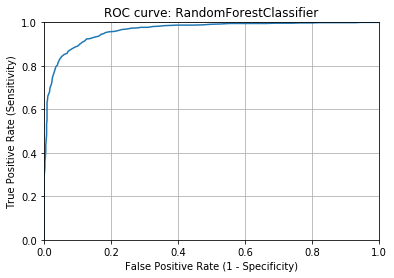

	ROC AUC SCORE: 0.90
	F1 Score: 0.90

Classification Report - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       796
           1       0.89      0.91      0.90       788

    accuracy                           0.90      1584
   macro avg       0.90      0.90      0.90      1584
weighted avg       0.90      0.90      0.90      1584






In [303]:
dtm_col = 'text_2'

X_train, X_test, y_train, y_test = train_test_split(X,y[y_col])
vect_title = prams['text']
X_train_dtm = vect_title.fit_transform(X_train[dtm_col])
X_test_dtm = vect_title.transform(X_test[dtm_col])

test_results = {}
cv_results = {}

for name,mdl in models.items():
    print('Model: {}'.format(name))
    mdl.fit(X_train_dtm, y_train)
    
    y_hat_proba = mdl.predict_proba(X_test_dtm)[:,1]
    plotROCCurve(y_test,y_hat_proba,name)
    y_hat = mdl.predict(X_test_dtm)
    print('\tROC AUC SCORE: {:.2f}'.format(roc_auc_score(y_test,y_hat)))
    test_results[name] = {'ROC_AUC':'{:.2f}'.format(roc_auc_score(y_test,y_hat))}
    print('\tF1 Score: {:.2f}\n'.format(f1_score(y_test,y_hat)))
    test_results[name].update({'F1_Score':'{:.2f}'.format(f1_score(y_test,y_hat))})
    print('Classification Report - {}\n{}'.format(name, classification_report(y_test,y_hat)))
    report = classification_report(y_test, y_hat,output_dict=True)
    test_results[name].update({'accuracy':str('{:.2f}'.format(report['accuracy']))})
    test_results[name].update({k:str('{:.2f}'.format(v)) for k,v in report['macro avg'].items()})
    print('\n\n')
    


# Conclusions
- SVC best, adding in Cnt of Uppercase words did help improve title prediction alone, but negatively impacted the highest performing model, which was SVC.  
- Next steps are to optimize VECT with SVC on the Text Column using Pipline and store model into joblib.
- Create final script to use in prod?